# REQUERIMIENTOS

In [1]:
#!pip install tensorflow
#!pip install scikit-learn==1.7.0
#!pip install xarray netCDF4 h5netcdf dask zarr

# MODULOS

In [2]:
#from google.colab import drive
#import xarray as xr
#drive.mount('/content/drive')

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
import os
import joblib
import xarray as xr

# FUNCIONES

In [4]:
def train_with_validation(model, X_train, y_train, epochs=100, val_split=0.2):
    # Split de validación
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=42)

    # Entrenar época por época y evaluar
    train_losses, val_scores = [], []
    model.warm_start = True

    # Suprimir warnings de convergencia (esperados en nuestro método)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        for epoch in range(1, epochs+1):  # Época por época
            model.max_iter = epoch
            model.fit(X_tr, y_tr)
            train_losses.append(model.loss_curve_[-1])  # Último loss
            val_scores.append(mean_squared_error(y_val, model.predict(X_val)))  # MSE en validación

    return train_losses, val_scores, list(range(1, epochs+1))

# PATHS

In [4]:
path_datos = '/content/drive/MyDrive/2025-S1/Monitoria_ada/datos/'
path_datos = '/workspaces/ADA-2025S1/datos/'
path_modelos = '/content/drive/MyDrive/2025-S1/Monitoria_ada/modelos/'
path_modelos = '/workspaces/ADA-2025S1/datos/modelos/'

# DATOS

In [9]:
chelsa = xr.open_zarr(path_datos + 'CHELSA_PPT_COL.zarr')
era5_ppt = xr.open_zarr(path_datos + 'ERA5_TP_COL.zarr')

In [7]:
min_lat, max_lat = 6.5, 7.5  # Aproximado, se puede ajustar
min_lon, max_lon = -76, -75.0 # Aproximado, se puede ajustar

chelsa_cut = chelsa.sel(lat=slice(min_lat, max_lat),
                        lon=slice(min_lon, max_lon))

era5_cut = era5_ppt.sel(latitude=slice(max_lat,min_lat),
                      longitude=slice(min_lon, max_lon))
era5_cut = era5_cut.rename({'valid_time': 'time'})

min_date_overall = max(chelsa_cut.time.min().values, era5_cut.time.min().values)
max_date_overall = min(chelsa_cut.time.max().values, era5_cut.time.max().values)

era5_cut = era5_cut.sel(time=slice(min_date_overall, max_date_overall)) * 1000
chelsa_cut = chelsa_cut.sel(time=slice(min_date_overall, max_date_overall)) *86400

In [8]:
chelsa_cut

<xarray.Dataset> Size: 168MB
Dimensions:  (lat: 40, lon: 40, time: 13149)
Coordinates:
  * lat      (lat) float64 320B 6.512 6.537 6.562 6.587 ... 7.437 7.462 7.487
  * lon      (lon) float64 320B -75.99 -75.96 -75.94 ... -75.06 -75.04 -75.01
  * time     (time) datetime64[ns] 105kB 1979-01-01 1979-01-02 ... 2014-12-31
Data variables:
    pr       (time, lat, lon) float64 168MB dask.array<chunksize=(13149, 30, 30), meta=np.ndarray>
Attributes:
    aggregate:    This is a spatial aggregate of the file with isimip_id=0390...
    caution:      In contrast to the ISIMIP standard, latitude values in this...
    comment:      Values of pr in this file are packed for storage reasons; u...
    contact:      ISIMIP cross-sectoral science team <info@isimip.org> <https...
    institution:  Potsdam Institute for Climate Impact Research (PIK) and Swi...
    isimip_id:    c214f17f-bc40-471d-af75-9ad75a0592db
    project:      Inter-Sectoral Impact Model Intercomparison Project phase 3...
    references:   Karger et al. (2021) <https://doi.org/10.48364/ISIMIP.83680...
    summary:      WFDE5 over land merged with ERA5 over the ocean (W5E5) v1.0...
    title:        CHELSA-W5E5 v1.0: W5E5 v1.0 downscaled with CHELSA v2.0, ag...

In [9]:
era5_cut

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 5, longitude: 5, time: 13149)
Coordinates:
  * latitude   (latitude) float64 40B 7.5 7.25 7.0 6.75 6.5
  * longitude  (longitude) float64 40B -76.0 -75.75 -75.5 -75.25 -75.0
  * time       (time) datetime64[ns] 105kB 1979-01-01 1979-01-02 ... 2014-12-31
Data variables:
    tp         (time, latitude, longitude) float32 1MB dask.array<chunksize=(8, 5, 5), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2025-01-27T16:22 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Text(0.5, 1.0, 'CHELSA - Primer Tiempo')

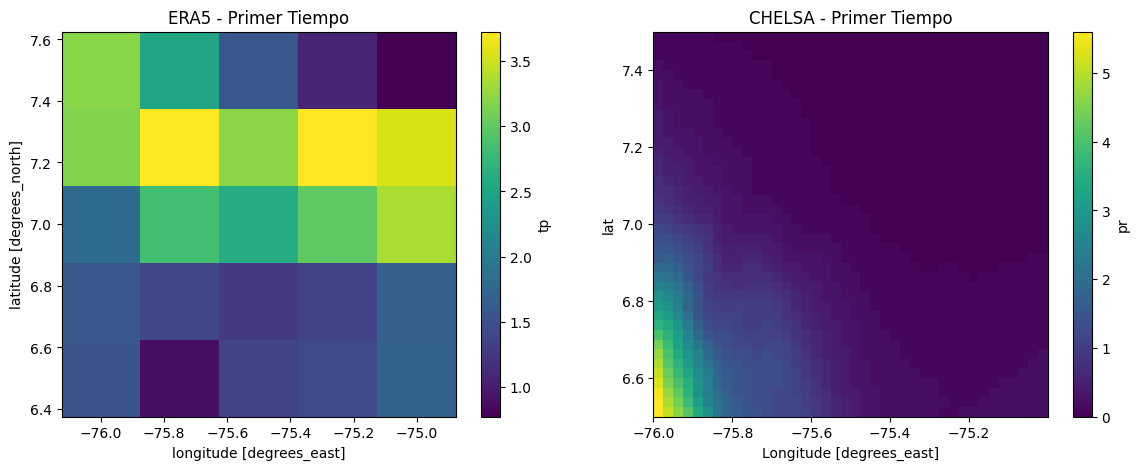

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
era5_cut.tp.isel(time=0).plot(ax=axes[0])
chelsa_cut.isel(time=0).pr.plot(ax=axes[1])
axes[0].set_title('ERA5 - Primer Tiempo')
axes[1].set_title('CHELSA - Primer Tiempo')

In [11]:
chelsa_precip = chelsa_cut['pr']
era5_precip = era5_cut['tp']

In [12]:
print(chelsa_precip.shape)
print(era5_precip.shape)

(13149, 40, 40)
(13149, 5, 5)


## RESHAPE

In [13]:
X = era5_precip.stack(pixels=['latitude', 'longitude'])
y = chelsa_precip.stack(pixels=['lat', 'lon'])
print("Shape era5:",X.shape,'-->',X.isnull().sum().compute().item())
print("Shape chelsa:",y.shape,'-->',y.isnull().sum().compute().item())

Shape era5: (13149, 25) --> 0
Shape chelsa: (13149, 1600) --> 0


## ESCALADO

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)#Para que no se roben la variabilidad

## TRAIN-TEST SPLIT

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# MODELOS

## MODELO 1

In [16]:
mlp1 = MLPRegressor(loss='squared_error',
                   hidden_layer_sizes=(1,),
                   activation='relu',
                   solver='adam')
train1, val1, epochs1 = train_with_validation(mlp1, X_train, y_train,epochs=100)

### CURVA DE APRENDIZAJE

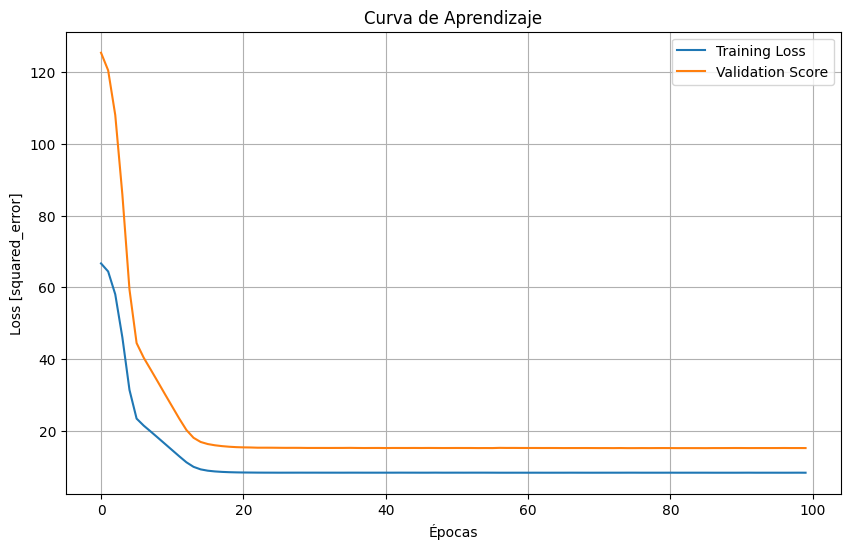

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train1, label='Training Loss')
plt.plot(val1, label='Validation Score')
plt.xlabel('Épocas')
plt.ylabel('Loss [squared_error]')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid(True)

### PREDICCIÓN

In [18]:
y_pred = mlp1.predict(X_test)
y_pred_da = xr.DataArray(
    y_pred,
    dims=y_test.dims,
    coords=y_test.coords)

### METRICAS

In [19]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}")

MSE: 17.399829951061683, R²: 0.7304643994654165


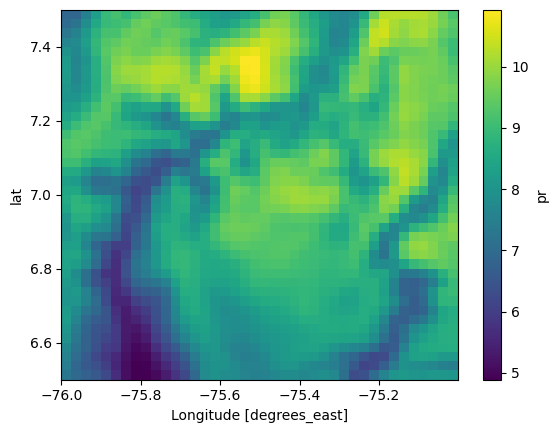

In [38]:
y_test.unstack('pixels').mean(dim='time').plot()

Text(0.5, 1.0, 'PRED - Primer Tiempo')

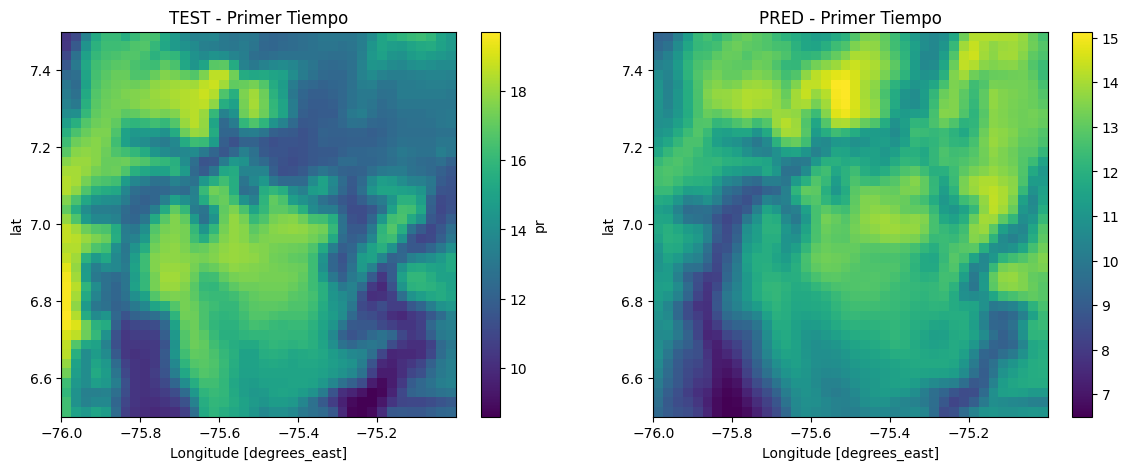

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
y_test.unstack('pixels').isel(time=0).plot(ax=axes[0])
y_pred_da.unstack('pixels').isel(time=0).plot(ax=axes[1])
axes[0].set_title('TEST - Primer Tiempo')
axes[1].set_title('PRED - Primer Tiempo')

In [51]:
data_test = y_test.unstack('pixels').sortby('time')
data_pred = y_pred_da.unstack('pixels').sortby('time')

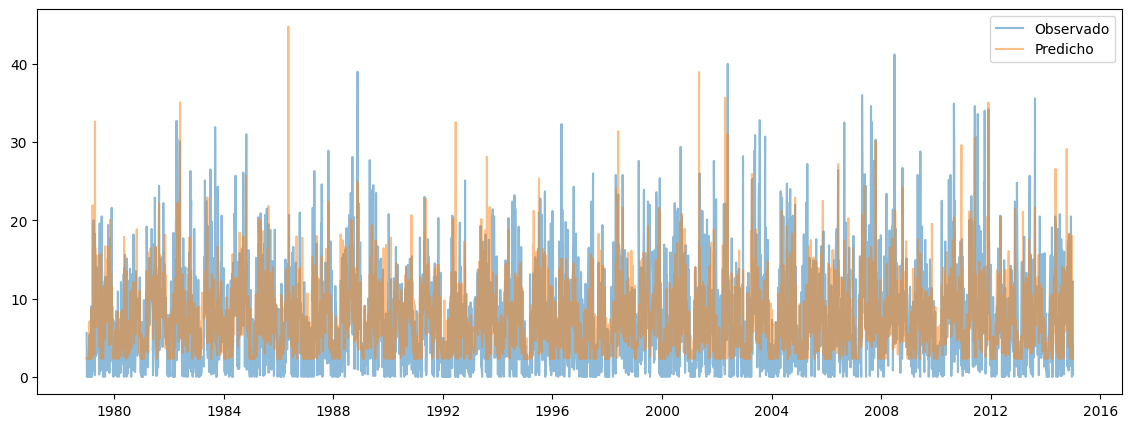

In [59]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
ax.plot(data_test.time,data_test.isel(lon=0,lat=0),alpha=.5,label ='Observado')
ax.plot(data_pred.time,data_pred.isel(lon=0,lat=0),alpha=.5,label ='Predicho')
plt.legend()

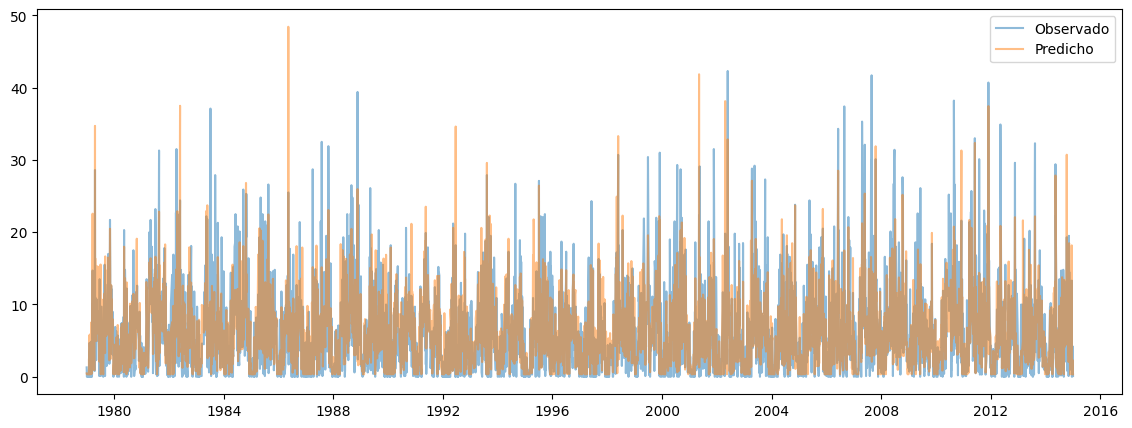

In [58]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
ax.plot(data_test.time,data_test.isel(lon=9,lat=5),alpha=.5,label ='Observado')
ax.plot(data_pred.time,data_pred.isel(lon=9,lat=5),alpha=.5,label ='Predicho')
plt.legend()

### GUARDAR MODELO

In [21]:
os.makedirs(path_modelos, exist_ok=True)
joblib.dump(mlp1, os.path.join(path_modelos, 'modelo_001.jbl'))

['/content/drive/MyDrive/2025-S1/Monitoria_ada/modelos/modelo_001.jbl']

## MODELO 2

In [22]:
mlp2 = MLPRegressor(loss='squared_error',
                   hidden_layer_sizes=(40,100,200),
                   activation='tanh',
                   solver='adam')
train2, val2, epochs2 = train_with_validation(mlp2, X_train, y_train,epochs=100)

### CURVA DE APRENDIZAJE

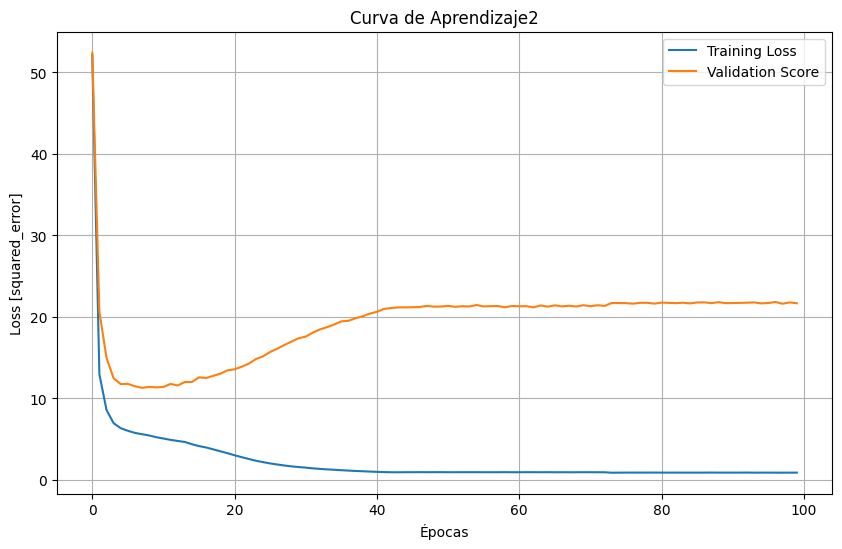

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train2, label='Training Loss')
plt.plot(val2, label='Validation Score')
plt.xlabel('Épocas')
plt.ylabel('Loss [squared_error]')
plt.title('Curva de Aprendizaje2')
plt.legend()
plt.grid(True)

### PREDICCION

In [24]:
y_pred2 = mlp2.predict(X_test)
y_pred_da2 = xr.DataArray(
    y_pred2,
    dims=y_test.dims,
    coords=y_test.coords)

### METRICAS

In [25]:
mse2 = mean_squared_error(y_test, y_pred2)
r22 = r2_score(y_test, y_pred2)
print(f"MSE: {mse2}, R²: {r22}")

MSE: 23.48234748695501, R²: 0.6381313596176652


Text(0.5, 1.0, 'PRED - Primer Tiempo')

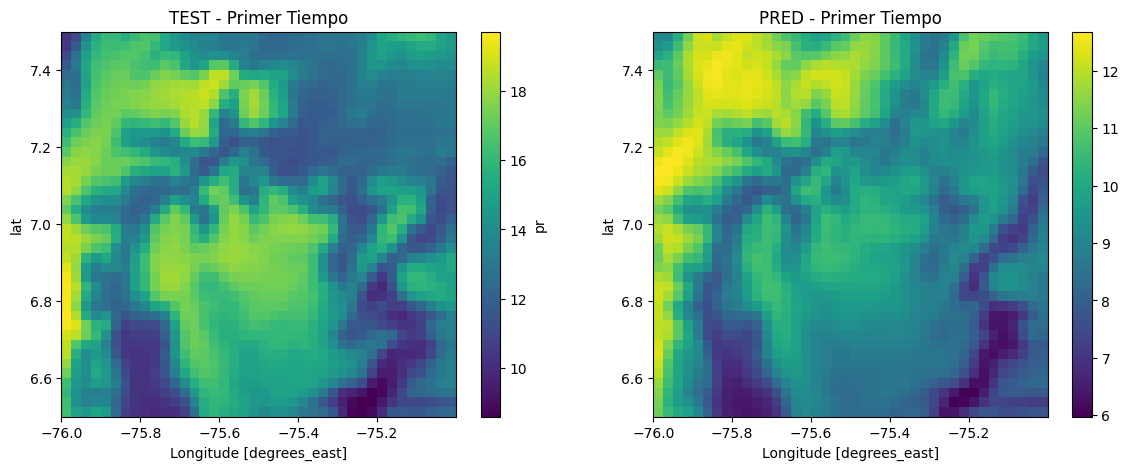

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
y_test.unstack('pixels').isel(time=0).plot(ax=axes[0])
y_pred_da2.unstack('pixels').isel(time=0).plot(ax=axes[1])
axes[0].set_title('TEST - Primer Tiempo')
axes[1].set_title('PRED - Primer Tiempo')

### GUARDAR MODELO

In [27]:
os.makedirs(path_modelos, exist_ok=True)
joblib.dump(mlp2, os.path.join(path_modelos, 'modelo_002.jbl'))

['/content/drive/MyDrive/2025-S1/Monitoria_ada/modelos/modelo_002.jbl']

# ANALISIS CONJUNTO

## RESIDUALES

In [28]:
residuals_mod1 = (y_test - y_pred).unstack('pixels')
residuals_mod2 = (y_test - y_pred2).unstack('pixels')

In [29]:
residuals_mean_mod1 = residuals_mod1.mean(dim='time')
residuals_mean_mod2 = residuals_mod2.mean(dim='time')
vmin = min(residuals_mean_mod1.min().compute().item(), residuals_mean_mod2.min().compute().item())
vmax = max(residuals_mean_mod1.max().compute().item(), residuals_mean_mod2.max().compute().item())

Text(0.5, 1.0, 'Promedio Residuales - Modelo 002')

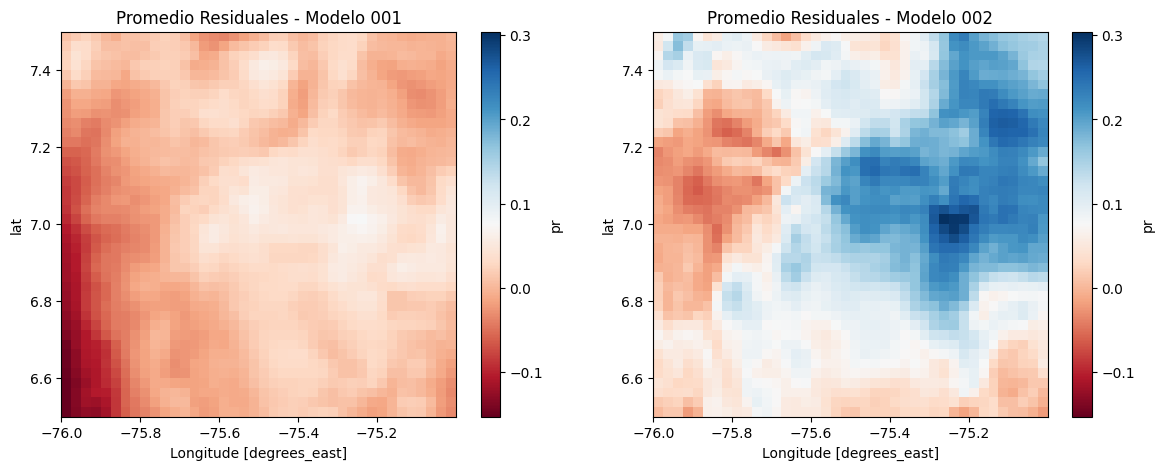

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
residuals_mean_mod1.plot(ax=axes[0], vmin=vmin, vmax=vmax,cmap='RdBu')
residuals_mean_mod2.plot(ax=axes[1], vmin=vmin, vmax=vmax,cmap='RdBu')
axes[0].set_title('Promedio Residuales - Modelo 001')
axes[1].set_title('Promedio Residuales - Modelo 002')

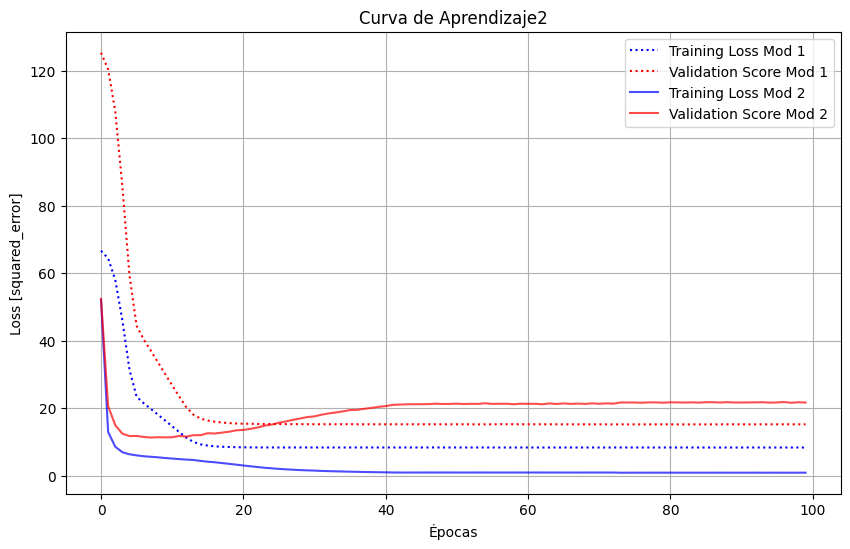

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(train1, label='Training Loss Mod 1',ls=':',color='blue')
plt.plot(val1, label='Validation Score Mod 1',ls=':',color='red')
plt.plot(train2, label='Training Loss Mod 2',color='blue',alpha=.7)
plt.plot(val2, label='Validation Score Mod 2',color='red',alpha=.7)
plt.xlabel('Épocas')
plt.ylabel('Loss [squared_error]')
plt.title('Curva de Aprendizaje2')
plt.legend()
plt.grid(True)